In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np
import scipy as scp
from statsmodels.tsa.ar_model import AutoReg
from itertools import product
from pylab import rcParams
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Подготовка данных (формирование временного ряда из данных -> создание матрицы)

In [3]:
our_columns = ['icethic_cea', 'iceconc','uice_ipa', 'vice_ipa','snowthic_cea']
df = pd.read_csv('arctic_results/ts_features.csv', header = None)
df.columns = our_columns
times = pd.date_range('2012-01-01', periods=len(df.index), freq='1h')
df.index = times

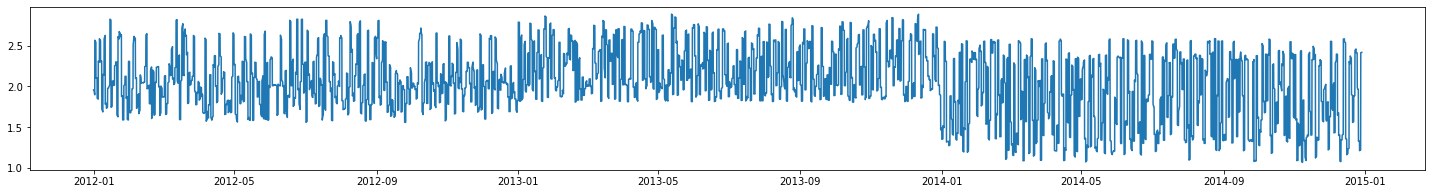

In [4]:
our_data = df['icethic_cea']
plt.subplots(figsize=(25, 3))
plt.plot(our_data)
plt.show()

In [5]:
df['dt'] = df.index
df['dt']=df['dt'].dt.round('1d')
dc = {column: 'mean' for column in our_columns}
df_daily = df.groupby('dt').agg(dc)

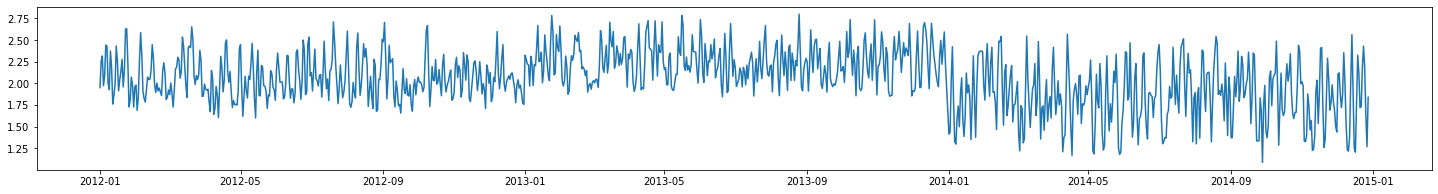

In [64]:
all_data = df_daily['icethic_cea'][:-1]
plt.subplots(figsize=(25, 3))
plt.plot(our_data)
plt.show()

In [65]:
all_data.shape

(1093,)

# Делим данные на train & test

In [67]:
percent_of_train_data = 60
index_split = all_data.shape[0] // 100 * percent_of_train_data
train_data = all_data[:index_split]
test_data = all_data[index_split:]

print(train_data.shape, test_data.shape)

(600,) (493,)


In [118]:
number_of_data_in_rw = (all_data.shape[0] // 100 * 63) # 63
step = 10

print(number_of_data_in_rw, step)

630 10


In [119]:
start_idx = 0
mtrx = []
while start_idx + number_of_data_in_rw < all_data.shape[0]:
    mtrx.append(all_data[start_idx:start_idx + number_of_data_in_rw])
    start_idx += step

mtrx = np.array(mtrx)

In [120]:
mtrx.shape

(47, 630)

# SVD

In [78]:
from numpy import linalg

In [121]:
result = linalg.svd(mtrx, full_matrices=False)

In [122]:
result[2].shape

(47, 630)

In [103]:
t = pd.DataFrame(result[2])

In [123]:
criterii = np.median(result[1]) * (4/3)
print(criterii)
comp = result[1][result[1] >= criterii]
print(comp)
print(result[1]) 

8.505801405871575
[364.27063561  19.84061403  11.89579632   9.04947177   8.94671904
   8.87338194]
[364.27063561  19.84061403  11.89579632   9.04947177   8.94671904
   8.87338194   8.28567964   8.16059362   7.98975118   7.97213962
   7.68999051   7.65789952   7.61096748   7.4622316    7.40618718
   7.3571318    7.07214195   6.98982896   6.87916099   6.81843432
   6.59996813   6.51318401   6.43271987   6.37935105   6.3476496
   6.31549919   6.2997501    6.19039057   6.04175375   5.9169576
   5.86298297   5.80746788   5.67844253   5.59679562   5.43683383
   5.40791846   5.3390726    5.17780452   5.0899315    5.02657608
   4.88748762   4.82743793   4.79108451   4.78155675   4.71502763
   4.53788707   4.4865054 ]


In [55]:
t.head(2)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.057988,-0.059598,-0.060364,-0.058849,-0.058720,-0.058128,-0.058798,-0.059662,-0.058925,-0.058995,...,-0.056393,-0.056925,-0.058816,-0.059759,-0.056048,-0.054309,-0.055132,-0.056506,-0.056743,-0.055994
1,-0.040778,-0.024149,-0.050767,-0.086169,-0.078045,-0.035405,-0.060745,-0.082260,-0.081120,-0.041015,...,0.072405,0.081599,0.043875,0.013751,0.063382,0.079210,0.111333,0.139961,0.086801,0.050382


In [125]:
r = len(comp) + 1

In [126]:
V_r = result[2][1:r, :]
print(V_r.shape)

(6, 630)


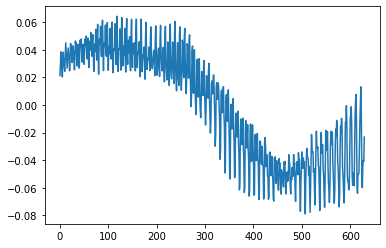

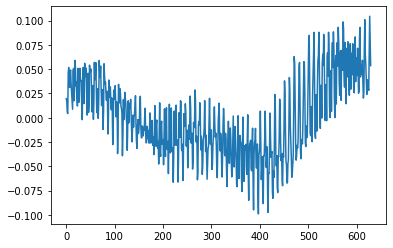

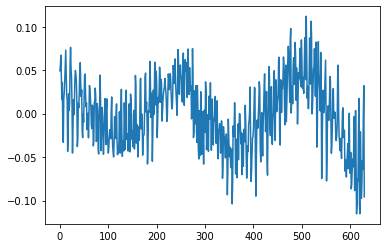

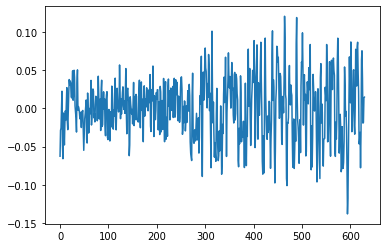

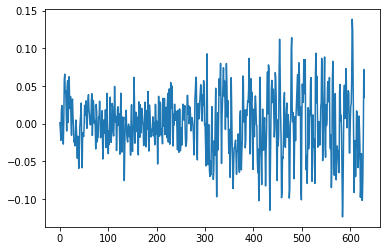

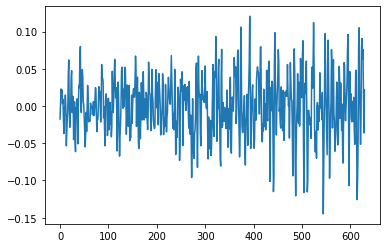

In [127]:
for dinamic in V_r:
    plt.plot(dinamic)
    plt.show()

In [390]:
# plt.pcolor(V_r)
# plt.colorbar()
# plt.show()

# TEST DMD

In [128]:
from pydmd import DMD
from pydmd import MrDMD

In [129]:
dmd = DMD(svd_rank=r-1)
dmd.fit(V_r[:-1])

In [110]:
A = dmd.atilde

In [352]:
print(A.shape, V_r[:-1].shape)

(5, 5) (5, 630)


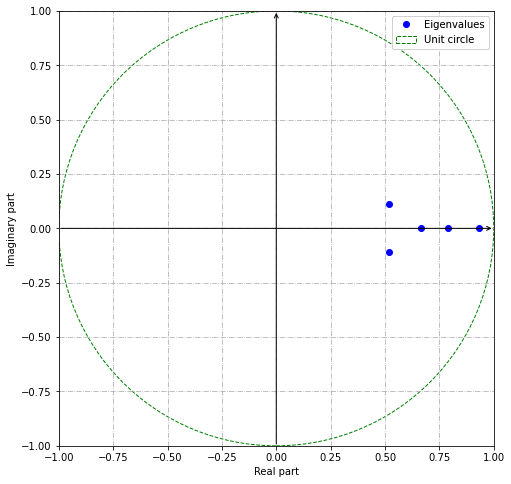

In [356]:
dmd.plot_eigs(show_axes=True, show_unit_circle=True)

In [139]:
percent_of_train_data = 60
index_split = V_r.shape[1] // 100 * percent_of_train_data
train_data = V_r[:, :index_split]
test_data = V_r[:, index_split:]

X_test = np.arange(V_r.shape[1])[index_split:]

print(train_data.shape, test_data.shape)

(6, 360) (6, 270)


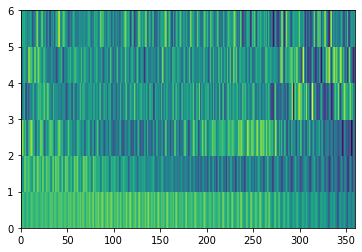

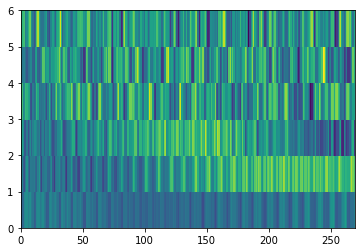

In [141]:
plt.pcolor(train_data)
plt.show()
plt.pcolor(test_data)
plt.show()

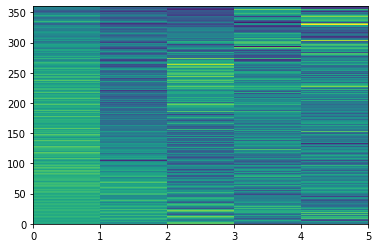

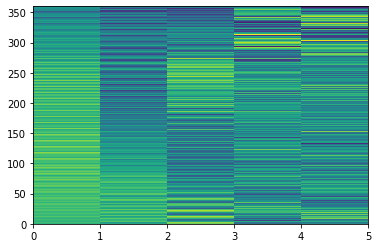

(360, 5) (360, 1)
(360, 6)


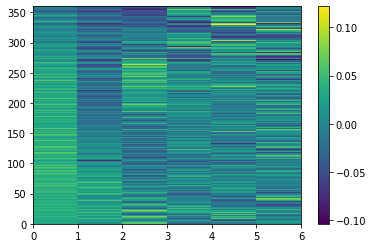

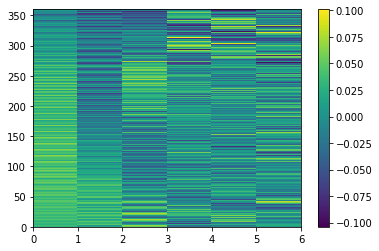

In [142]:
sub_dmd = DMD(svd_rank=-1)

dmd = MrDMD(sub_dmd, max_level=7, max_cycles=1)
dmd.fit(X=train_data[:-1])
plt.pcolor(np.real(dmd.reconstructed_data.T))
plt.show()
plt.pcolor(train_data[:-1].T)
plt.show()

print(np.real(dmd.reconstructed_data.T).shape, train_data[-1].reshape(train_data[-1].shape[0], 1).shape)
end_res = np.hstack((np.real(dmd.reconstructed_data.T), train_data[-1].reshape(train_data[-1].shape[0], 1)))
print(end_res.shape)

plt.pcolor(end_res)
plt.colorbar()
plt.show()
plt.pcolor(train_data.T)
plt.colorbar()
plt.show()

# plt.pcolor(V_r.T)

In [150]:
np.real(dmd.reconstructed_data.T)[-1].shape

(5,)

In [165]:
test = predict(dmd, X_test, np.real(dmd.reconstructed_data.T)[-1])

ValueError: need at least one array to concatenate

In [61]:
temp = 0
for level, leaf, iter_dmd in dmd.enumerate():
    if temp != level:
        print(level, )
        iter_dmd.atilde.shape 

0 0 (5, 5)
1 0 (5, 5)
1 1 (5, 5)
2 0 (5, 5)
2 1 (5, 5)
2 2 (5, 5)
2 3 (5, 5)
3 0 (5, 5)
3 1 (5, 5)
3 2 (5, 5)
3 3 (5, 5)
3 4 (5, 5)
3 5 (5, 5)
3 6 (5, 5)
3 7 (5, 5)
4 0 (5, 5)
4 1 (5, 5)
4 2 (5, 5)
4 3 (5, 5)
4 4 (5, 5)
4 5 (5, 5)
4 6 (5, 5)
4 7 (5, 5)
4 8 (5, 5)
4 9 (5, 5)
4 10 (5, 5)
4 11 (5, 5)
4 12 (5, 5)
4 13 (5, 5)
4 14 (5, 5)
4 15 (5, 5)
5 0 (5, 5)
5 1 (5, 5)
5 2 (5, 5)
5 3 (5, 5)
5 4 (5, 5)
5 5 (5, 5)
5 6 (5, 5)
5 7 (5, 5)
5 8 (5, 5)
5 9 (5, 5)
5 10 (5, 5)
5 11 (5, 5)
5 12 (5, 5)
5 13 (5, 5)
5 14 (5, 5)
5 15 (5, 5)
5 16 (5, 5)
5 17 (5, 5)
5 18 (5, 5)
5 19 (5, 5)
5 20 (5, 5)
5 21 (5, 5)
5 22 (5, 5)
5 23 (5, 5)
5 24 (5, 5)
5 25 (5, 5)
5 26 (5, 5)
5 27 (5, 5)
5 28 (5, 5)
5 29 (5, 5)
5 30 (5, 5)
5 31 (5, 5)
6 0 (5, 5)
6 1 (5, 5)
6 2 (5, 5)
6 3 (5, 5)
6 4 (5, 5)
6 5 (5, 5)
6 6 (5, 5)
6 7 (5, 5)
6 8 (5, 5)
6 9 (5, 5)
6 10 (5, 5)
6 11 (5, 5)
6 12 (5, 5)
6 13 (5, 5)
6 14 (5, 5)
6 15 (5, 5)
6 16 (5, 5)
6 17 (5, 5)
6 18 (5, 5)
6 19 (5, 5)
6 20 (5, 5)
6 21 (5, 5)
6 22 (5, 5)
6 23 (5, 5)
6

In [164]:
def predict_one(mrdmd, X):
    # return np.sum(np.array([np.hstack([mrdmd.dmd_tree[level, leaf].predict(X) for leaf in mrdmd.dmd_tree.index_leaves(level)]) for level in mrdmd.dmd_tree.levels]), axis=0)
    some_stacks = []
    for level in mrdmd.dmd_tree.levels:
        stack = []
        for leaf in mrdmd.dmd_tree.index_leaves(level):
            if mrdmd.dmd_tree[level, leaf].modes.shape[-1] == 0:
                continue
            print("modes", mrdmd.dmd_tree[level, leaf].modes, mrdmd.dmd_tree[level, leaf].modes.shape)
            print("eigs", np.diag(mrdmd.dmd_tree[level, leaf].eigs), np.diag(mrdmd.dmd_tree[level, leaf].eigs).shape)
            print(X, X.shape)
            pred_data = mrdmd.dmd_tree[level, leaf].predict(X)
            stack.append(pred_data)
        leaf_stack = np.hstack(stack)
        some_stacks.append(leaf_stack)
    return(np.sum(np.array(some_stacks)))

In [153]:
def predict(mrdmd, X, last_value):
    for _ in range(len(X)):
        current_val = predict_one(mrdmd, last_value)
        print(current_val.shape)

In [54]:
dmd.eigs.shape

(371,)

In [52]:
operators = [partial_dmd.atilde for partial_dmd in dmd]

In [53]:
len(operators)

255

In [23]:
for iter_mode in dmd.modes:
    print(iter_mode)

[-7.26754598e-01+0.j         -7.37239622e-01+0.j
 -9.15067886e-01+0.j         -7.73548856e-01+0.j
  7.81527929e-01+0.j          6.93582696e-01+0.j
  5.44717379e-01+0.j         -5.46589456e-01+0.j
  7.59518751e-01+0.j          9.03732073e-01+0.j
 -8.81463276e-01+0.j         -6.78369490e-01+0.j
 -6.59648390e-01+0.j          5.35205654e-01+0.j
 -6.03926381e-01+0.j          8.06984426e-01+0.j
  3.42424354e-01+0.32862857j  3.42424354e-01-0.32862857j
  6.87014702e-01+0.j         -4.37021722e-01+0.j
 -3.08502045e-01+0.j         -3.79613854e-01+0.j
 -2.50089606e-01+0.j          6.37074091e-01+0.j
  7.24758513e-01+0.j          9.19079858e-01+0.j
 -8.96945292e-01+0.j          9.08306271e-01+0.j
  8.92129797e-01+0.j         -8.56678064e-01+0.j
  7.76996958e-01+0.j         -6.69715598e-01+0.j
 -5.77264709e-01+0.j          5.14778741e-01+0.j
  5.36618188e-01+0.j         -5.93763244e-01+0.j
  3.31170482e-01+0.j         -7.85686565e-01+0.j
  6.40318287e-01+0.j         -1.88657975e-01+0.j
 -7.33787480

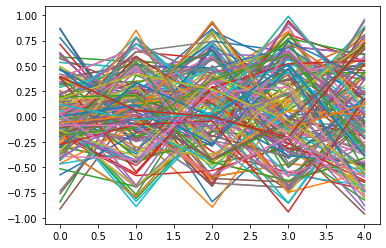

In [24]:
pmodes = dmd.partial_modes(level=7)
fig = plt.plot(pmodes.real)

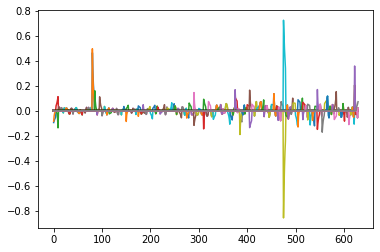

In [25]:
pdyna = dmd.partial_dynamics(level=7)
fig = plt.plot(pdyna.real.T)

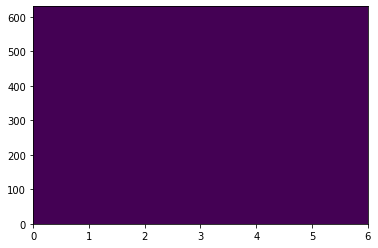

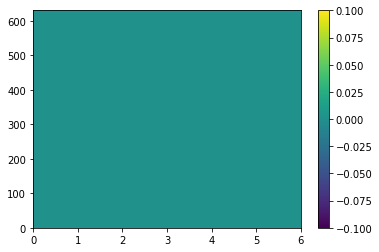

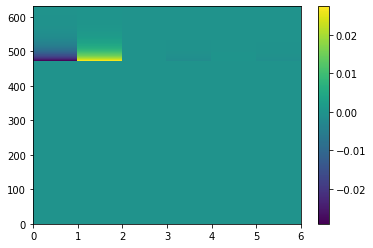

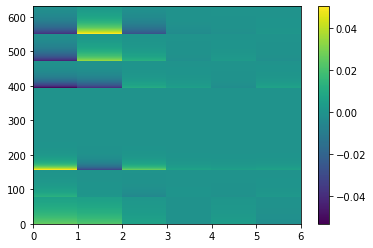

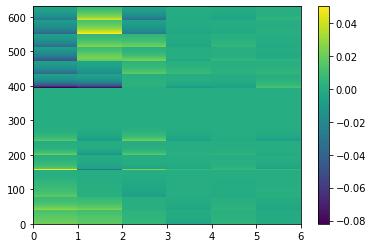

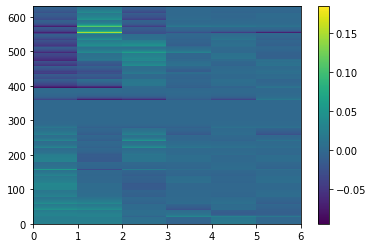

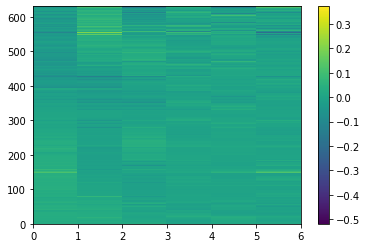

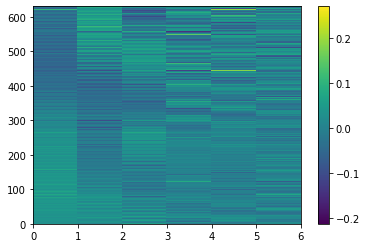

In [32]:
pdata = dmd.partial_reconstructed_data(level=0)
plt.pcolor(np.real(pdata).T)
plt.show()
for i in range(1, 8):
    pdata += dmd.partial_reconstructed_data(level=i)
    plt.pcolor(np.real(pdata).T)
    plt.colorbar()
    plt.show()

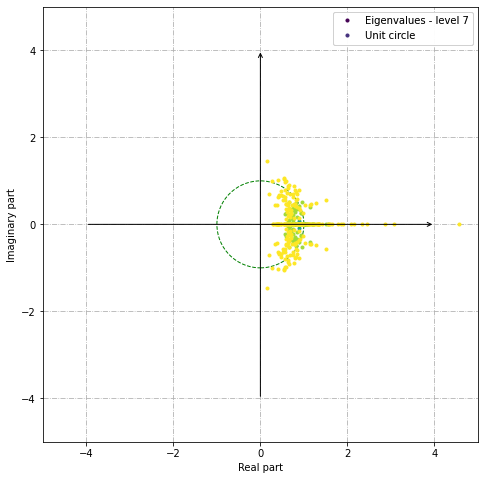

In [290]:
dmd.plot_eigs(show_axes=True, show_unit_circle=True, figsize=(8, 8))

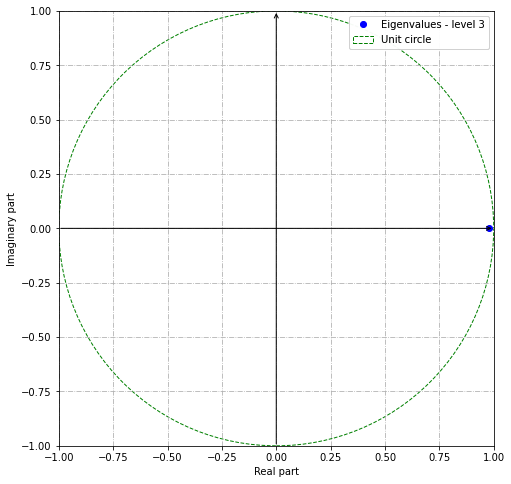

In [370]:
dmd.plot_eigs(show_axes=True, show_unit_circle=True, figsize=(8, 8), level=3, node=0)